## Setup

In [51]:
framework = 'PyTorch' #@param ['Turi', 'PyTorch']

if framework == 'Turi':
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G4jdZzPDev5mgLOTnpBm8DQPO9NsLBYn' -O bd_case.sframe.7z
  !7z x bd_case.sframe.7z
  !pip install turicreate

else:
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YQbiJAde7IptOIbBvaN1_z4MEVm0V1N3' -O bd_case.csv

--2022-01-24 15:17:13--  https://docs.google.com/uc?export=download&id=1YQbiJAde7IptOIbBvaN1_z4MEVm0V1N3
Resolving docs.google.com (docs.google.com)... 173.194.194.113, 173.194.194.102, 173.194.194.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.194.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f04q9368qjlmrua935p54o4ba70shdm7/1643037375000/16075663991289837783/*/1YQbiJAde7IptOIbBvaN1_z4MEVm0V1N3?e=download [following]
--2022-01-24 15:17:14--  https://doc-0g-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f04q9368qjlmrua935p54o4ba70shdm7/1643037375000/16075663991289837783/*/1YQbiJAde7IptOIbBvaN1_z4MEVm0V1N3?e=download
Resolving doc-0g-ao-docs.googleusercontent.com (doc-0g-ao-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-0g-ao-docs.googleusercontent.com (doc-0g-

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset
In această secțiune vom încărca datele din features.csv si grades.csv, dupa care le vom concatena si le vom afisa.

Vom utiliza framework-ul **pandas**.

In [198]:
featuretable = pd.read_csv('drive/MyDrive/features.csv')
gradestable = pd.read_csv('drive/MyDrive/grades.csv')

dataframe = pd.merge(featuretable, gradestable,on="label") # concatenez tabelele in functie de label
dataframe=dataframe[dataframe['grade'].notna()]
dataframe.head()

dataframe.drop(['Unnamed: 22'],axis=1,inplace=True) #elimin coloana Unnamed: 22

dataframe # vizualizez tabelele concatenate

,nr_crt,label,nr_clase,nr_errors,nr_inheritance,nr_virtual,nr_static,nr_global,nr_public,nr_private,nr_protected,nr_define,nr_template,nr_stl,nr_namespace,nr_enum,nr_struct,nr_cpp,nr_comments,nr_function,headers_size,sources_size,grade
0,0,student_27,11,605,0,3,2,0,17,1,2,6,1,10,4,0,0,12,4,39,3002,13697,5.01
2,2,student_17,12,1466,9,5,5,0,26,2,0,2,1,6,6,0,0,12,6,28,4497,38762,5.70
3,3,student_43,19,1121,6,3,2,0,31,1,7,19,1,56,19,0,0,20,6,111,12825,31678,5.77
4,4,student_64,26,742,1,1,5,0,35,3,1,3,1,22,3,2,0,25,45,83,6931,19647,5.84
6,6,student_26,18,1357,1,8,4,0,30,1,0,2,1,9,6,0,0,19,3,76,4447,29532,6.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,78,d77ae437b650edc0f4219d1834263632,1,396,0,0,4,0,1,1,0,0,0,1,1,0,0,1,0,18,3644,21565,4.32
78,79,9511dedd1cbb3bdd30d99869c90e64a2,0,396,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,21565,3.97
79,80,2591adf8fc3d96b7775ab0d49d3a9de7,15,1726,1,0,2,0,24,18,0,41,1,19,12,10,0,15,102,116,22074,38966,6.95
80,81,0889c6e3cb0c6cda88f0186c3dfb7625,0,94,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2123,5.00


Mai jos putem vizualiza modul in care variază nota in functie de numarul de erori.

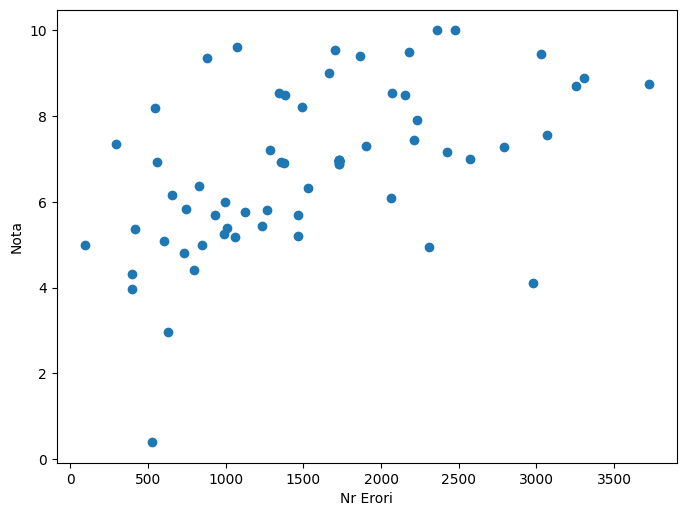

In [199]:
x = dataframe[1:5000]['nr_errors']
y = dataframe[1:5000]['grade']
plt.figure(figsize=(8,6), dpi=100)
plt.plot(x, y, 'o')
plt.ylabel("Nota")
plt.xlabel("Nr Erori")
plt.show()

### Data Split
Impartim datele in date de train si date de test cu ajutorul unei metode in SciKitLearn.

In [200]:
train_frame, test_frame = train_test_split(dataframe, test_size=0.2)

print('Total: {} \nTrain: {} \nTest: {}'.format(len(dataframe), len(train_frame), len(test_frame)))

Total: 70 
Train: 56 
Test: 14


### HomeworkDataset
Definim o clasa HomeworkDataset care extinde torch.utils.data.Dataset și care implementeaza metodele necesare pentru compatibilitatea cu DataLoader-ul din PyTorch

In [201]:
class HomeworkDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self._df = dataframe

    def __len__(self): 
        return len(self._df)

    def __getitem__(self, idx): #[]
        item = self._df.iloc[idx] 
        features=[]
        for i in self._df.columns[2:-1]:
          features.append(item[i])
        return {'features': torch.tensor(features, dtype=torch.float32),
                'labels' : torch.tensor([item['grade']], dtype=torch.float32)}

In [202]:
# Utilizam clasa wrapper Homework Dataset
train_set = HomeworkDataset(train_frame)
test_set = HomeworkDataset(test_frame)

# Printam al 5lea sample
train_set[5]

{'features': tensor([1.5000e+01, 1.7260e+03, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
         2.4000e+01, 1.8000e+01, 0.0000e+00, 4.1000e+01, 1.0000e+00, 1.9000e+01,
         1.2000e+01, 1.0000e+01, 0.0000e+00, 1.5000e+01, 1.0200e+02, 1.1600e+02,
         2.2074e+04, 3.8966e+04]), 'labels': tensor([6.9500])}

## Model
Implementam modelul IA (trebuie sa derivam din torch.nn.Module si sa implementam metodele __init__ si __forward__)

In [203]:
class RegressionModel(nn.Module):
    def __init__(self, in_feat=1, out_feat=1):
        super().__init__()
        self.fc = nn.Linear(in_feat, out_feat) # Definesc o retea neuronala cu un singur strat Fully Connected

    def forward(self, x):
        out = self.fc(x)
        return out

model = RegressionModel(20,1) # generez o instanță a modelului

## Train

### Hiperparametrii

In [204]:
LEARNING_RATE = 1e-10 # Rata de invatare
NR_EPOCHS = 10 # Numarul de epoci
BATCH_SIZE = 32 # Numarul de samples dintr-un batch

### Funcția cost (loss)
Vom utiliza Mean Squared Error (torch.nn.MSELoss) 

In [205]:
criterion = nn.MSELoss() #atentie: turi utilizeaza Root MSE

### Algoritmul de optimizare
Vom utiliza Stochastic Gradient Descent (torch.optim.SGD)

In [206]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

### Training Loop

In [207]:
# Pregatim o modalitate de loggare a informatiilor din timpul antrenarii
log_info = []

# Pregatim DataLoader-ul pentru antrenare
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Trecem modelul in modul train
model.train() 



########### Training Loop #############

# pentru fiecare epoca (1 epoca = o iteratie peste intregul set de date)
for epoch in range(NR_EPOCHS):
    print('Running epoch {}'.format(epoch))

    epoch_losses = []
    
    # pentru fiecare batch de BATCH_SIZE exemple din setul de date    
    for i, batch in enumerate(train_loader):

        inputs, labels = batch['features'], batch['labels']
        
        # anulam gradientii deja acumulati la nivelul retelei neuronale
        optimizer.zero_grad()

        # FORWARD PASS: trecem inputurile prin retea
        outputs = model(inputs)

        # Calculam LOSSul dintre etichetele prezise si cele reale
        loss = criterion(outputs, labels)

        # BACKPRPAGATION: calculam gradientii propagand LOSSul in retea
        loss.backward()

        # Utilizam optimizorul pentru a modifica parametrii retelei in functie de gradientii acumulati
        optimizer.step()

        # Salvam informatii despre antrenare (in cazul nostru, salvam valoarea LOSS)
        epoch_losses.append(loss.item()) 
    log_info.append((epoch, np.mean(epoch_losses)))

Running epoch 0
Running epoch 1
Running epoch 2
Running epoch 3
Running epoch 4
Running epoch 5
Running epoch 6
Running epoch 7
Running epoch 8
Running epoch 9


Realizam graficul modificarii LOSSului pe parcursul antrenării



Text(0, 0.5, 'LOSS')

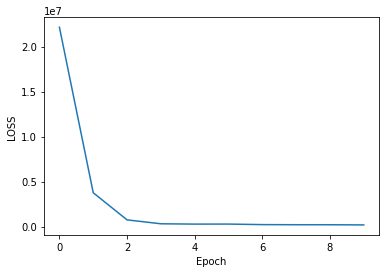

In [208]:
X = [x for x, loss in log_info]
Y = [loss for x, loss in log_info]
plt.plot(X,Y)
plt.xlabel("Epoch")
plt.ylabel("LOSS")

In [209]:
print(model.fc.weight, model.fc.bias)

Parameter containing:
tensor([[-0.0463,  0.0242,  0.0917, -0.0075,  0.0733,  0.1714,  0.2018,  0.1229,
          0.1000,  0.0061,  0.1564,  0.1656, -0.2073, -0.1392, -0.0677,  0.0100,
          0.1611, -0.1712, -0.0476,  0.0133]], requires_grad=True) Parameter containing:
tensor([0.0324], requires_grad=True)


###Salvare model 


In [212]:
torch.save(model.state_dict(),"model.pt")